In [3]:
import numpy as np
import os
import scipy.io as sio
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [11]:
# Regularization: (costmatrix - alpha*I)
subtype=['stroke', 'control']

dx = subtype[0]
cwd = os.getcwd()
data_dir = str(cwd) + '/data'
fc_dir =data_dir + '/precision/'
fc=sio.loadmat(fc_dir + dx + '/C_precision.mat')

fc=fc['C_precision']
intervals=[[0, 1], [1, 2], [2, 3], [3, 4]] #time point comparisons. 0=1, 1=2, etc.

session_swaps=list()
for i in range(0, 4):
    allswaps=list()
    alphas=[0, 0.0025, 0.0075, 0.0125]
    alphacounter = 0
    for alpha in alphas:
        print('Testing alpha: ' + str(alpha))
        nswaps=run_graph_matching_reg(intervals[i], fc, dx, alpha, alphacounter)
        print('Mean num. swaps: ' + str(np.mean(nswaps)))
        alphacounter = alphacounter +1
        allswaps.append(nswaps)
    session_swaps.append(allswaps)

Testing alpha: 0
0
Mean num. swaps: 0.2788773523685918
Testing alpha: 0.0025
1
Mean num. swaps: 0.10139519792342634
Testing alpha: 0.0075
2
Mean num. swaps: 0.015087605451005837
Testing alpha: 0.0125
3
Mean num. swaps: 0.0019467878001297857
Testing alpha: 0
0
Mean num. swaps: 0.2845997286295794
Testing alpha: 0.0025
1
Mean num. swaps: 0.10753052917232021
Testing alpha: 0.0075
2
Mean num. swaps: 0.013568521031207599
Testing alpha: 0.0125
3
Mean num. swaps: 0.004409769335142469
Testing alpha: 0
0
Mean num. swaps: 0.2787846481876332
Testing alpha: 0.0025
1
Mean num. swaps: 0.09879175550817342
Testing alpha: 0.0075
2
Mean num. swaps: 0.013859275053304903
Testing alpha: 0.0125
3
Mean num. swaps: 0.0023098791755508173
Testing alpha: 0
0
Mean num. swaps: 0.26361940298507464
Testing alpha: 0.0025
1
Mean num. swaps: 0.10615671641791045
Testing alpha: 0.0075
2
Mean num. swaps: 0.028171641791044776
Testing alpha: 0.0125
3
Mean num. swaps: 0.011567164179104477


In [9]:
def remap_cost_regularized(interval, fc, alpha):
    """Cost function: the cost of remapping each node in matrix A to every other node in matrix B. 
    Output is fed into graph matching algorithm. Regularization: (costmatrix - alpha*I) 
    where alpha is a regularization parameter controlling the degree to which a remapping
    to itself is preferred over remapping to any other node."""

    costmat_all=list()

    nROIs=fc[0][0].shape[0]
    #calculate cost between all ROIs
    for i in range(0,fc.shape[0]): #subject 
        if (dx == 'stroke' and i==5 and interval == [3,4]): #sub6 has no 4,5
            continue
        if (dx == 'stroke' and i==11 and (interval == [3,4] or interval == [2,3])): #sub12 has no 4,5 OR 3,4
            continue
        if (dx == 'stroke' and i==19 and (interval == [3,4] or interval == [2,3] or interval == [1,2])): #sub20 has no 4,5 OR 3,4 OR 2,3
            continue
        costmat=np.zeros((nROIs,nROIs))

        for x in range(0,nROIs): #x = time point 1.
            a=fc[i,interval[0]][x]

            for y in range(0,nROIs): #y = time point 2.
                b=fc[i,interval[1]][y]

                costmat[x,y]=distance.euclidean(a,b)
                
        costmat=costmat-alpha*np.eye(nROIs)
        costmat_all.append(costmat)

    return [costmat_all, nROIs]

def graph_matching_regularized(costmat_all, interval, nROIs, dx, alpha, alphacounter):
    """Runs graph matching w/ the Hungarian algorithm and saves outputs:
    
        cols_SXSY.txt - each row is a different subject. Values in each column represent the node
        in the latter time point that the node in the prior time point was mapped to.
        
        roichanges_SXSY.txt - each row is a different subject. Values in each column represent 
        whether the node was remapped to a DIFFERENT node than itself in the subsequent time point 
        (elements are 0 or 1, 1 if the node was remapped to a different node and 0 if the node was mapped to itself.
        Used to calculate remap frequency for each region, when averaged vertically (across subjects)."""
    
    results_dir = str(cwd) + '/results/jupyter/precision/'
    print(alphacounter)
    nROIs=fc[0][0].shape[0]
    nsubs=len(costmat_all) #test
    
    rows=np.zeros((nsubs,nROIs))
    cols=np.zeros((nsubs,nROIs))
    roichanges=np.zeros((nsubs,nROIs))
    truecols=range(0,nROIs)

    for i in range(0, nsubs):
        cost=costmat_all[i]
        rowind, colind=linear_sum_assignment(cost) #graph matching part.
        rows[i]=rowind
        cols[i]=colind

    np.savetxt(results_dir+ dx +'/cols_'+ 'S'+str(interval[0]+1)+'S'+ str(interval[1]+1)+'_alpha' + str(alphacounter)+'.txt', cols)

    for j in range(0,nsubs):
        for i in range(0,nROIs):
            if cols[j][i]!=truecols[i]:
                roichanges[j][i]=1 #indices that are switched

    allchanges=np.mean(roichanges,0)
    np.savetxt(results_dir + dx +'/roichanges_' + 'S'+str(interval[0]+1)+'S'+ str(interval[1]+1) +'_alpha' + str(alphacounter)+'.txt', allchanges)
    return [allchanges]

def run_graph_matching_reg(interval, fc, dx, alpha,alphacounter):
    """Calculate the cost of remapping across all subjects, and perform graph matching.
    Saves outputs to /results/jupyter/.../stroke and /controls."""
    [costmat_all, nROIs]=remap_cost_regularized(interval, fc, alpha)
    nswaps=graph_matching_regularized(costmat_all, interval, nROIs, dx, alpha,alphacounter)
    return nswaps


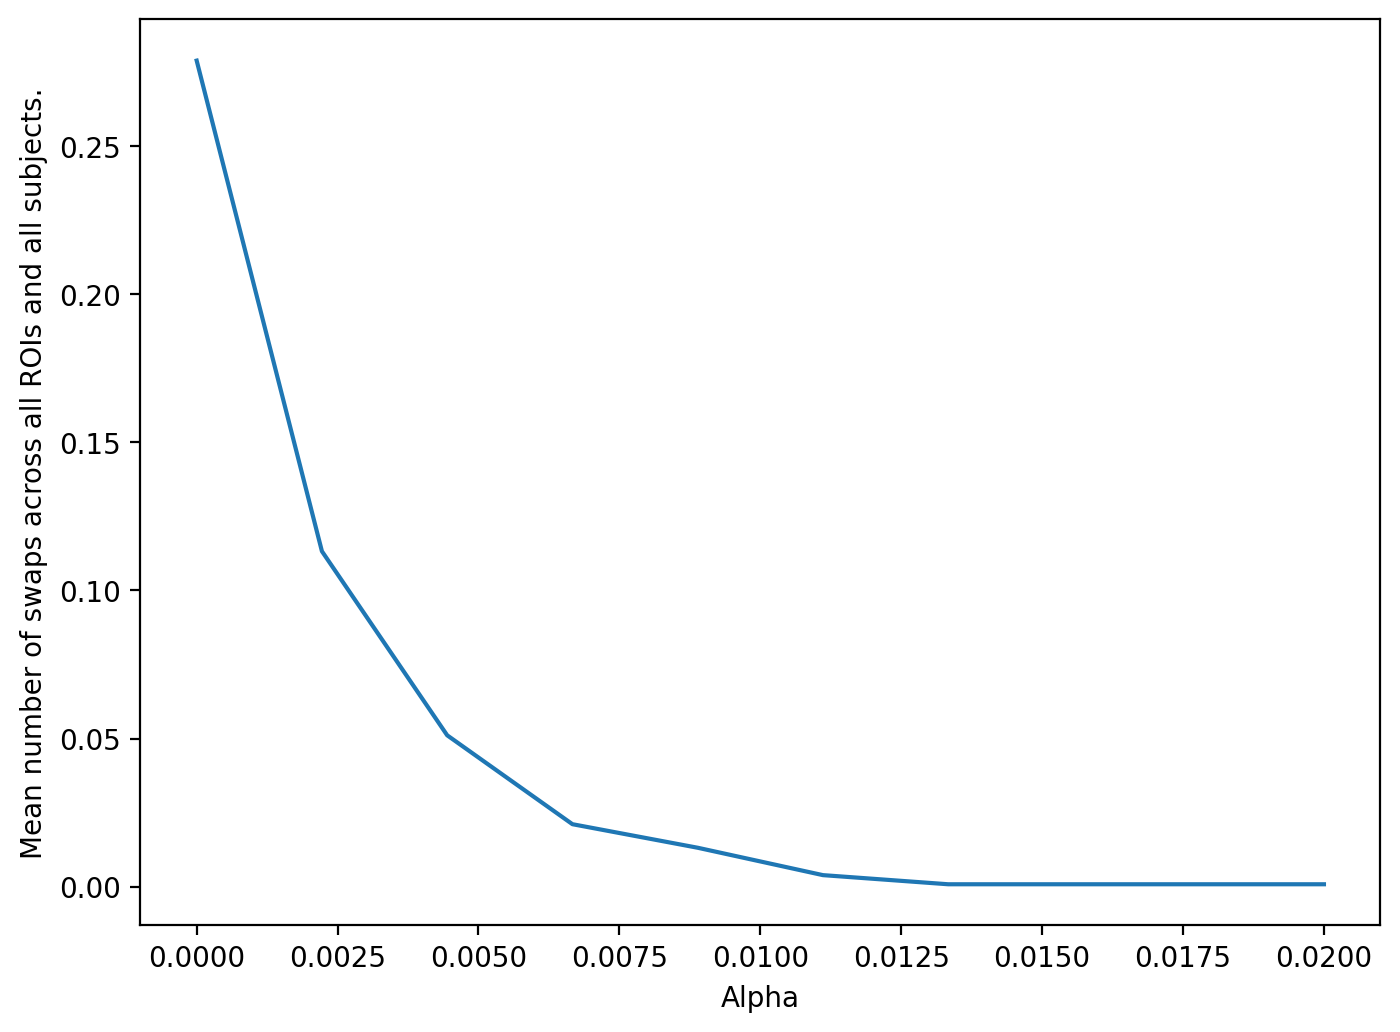

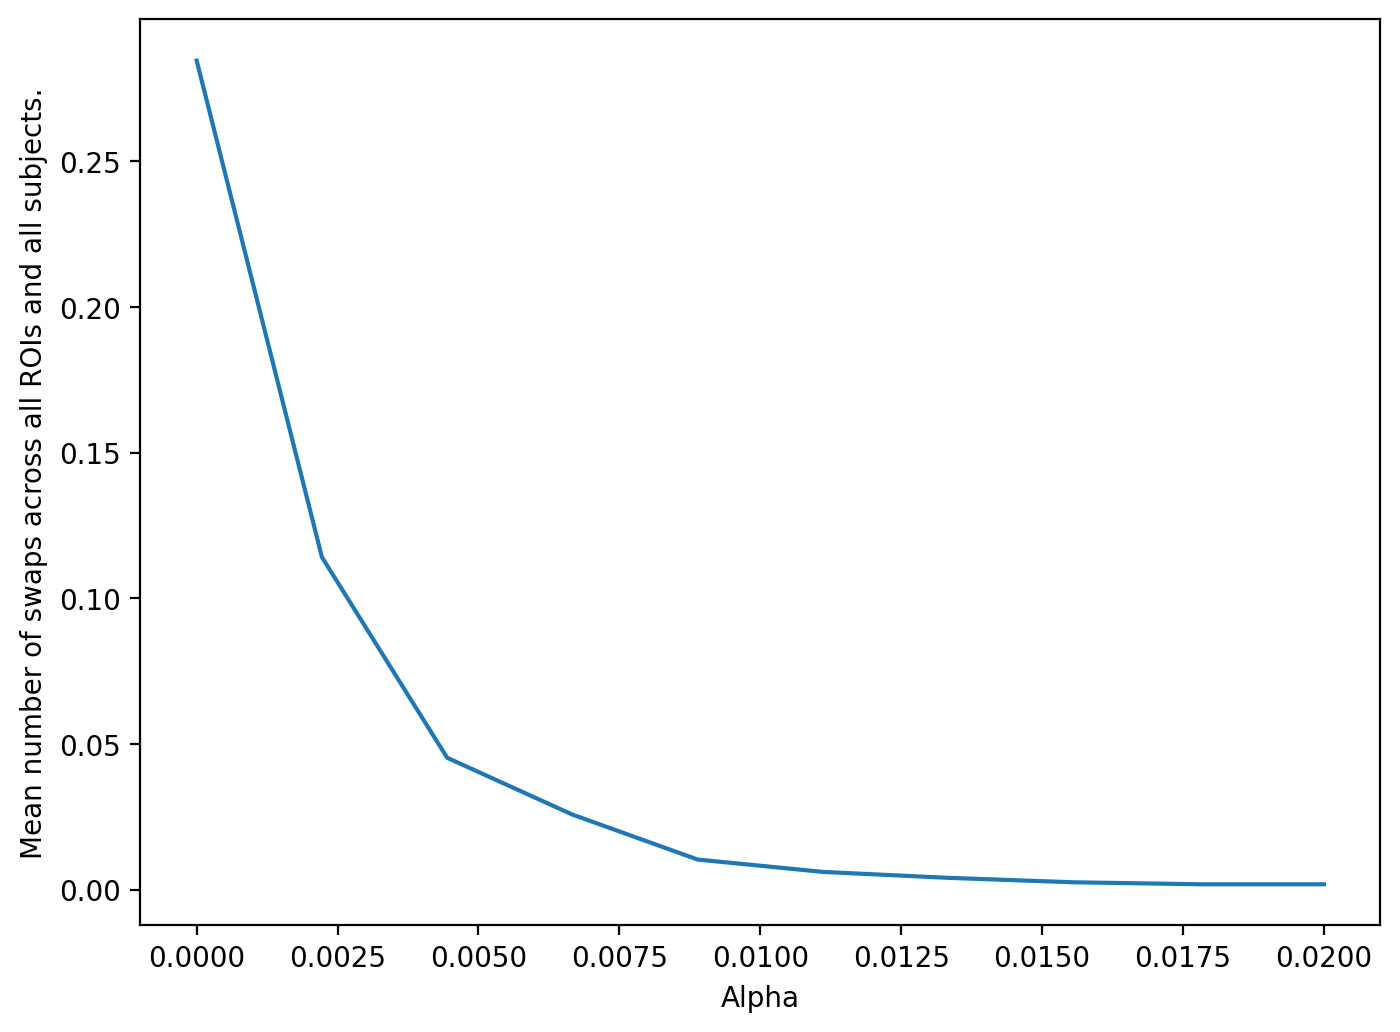

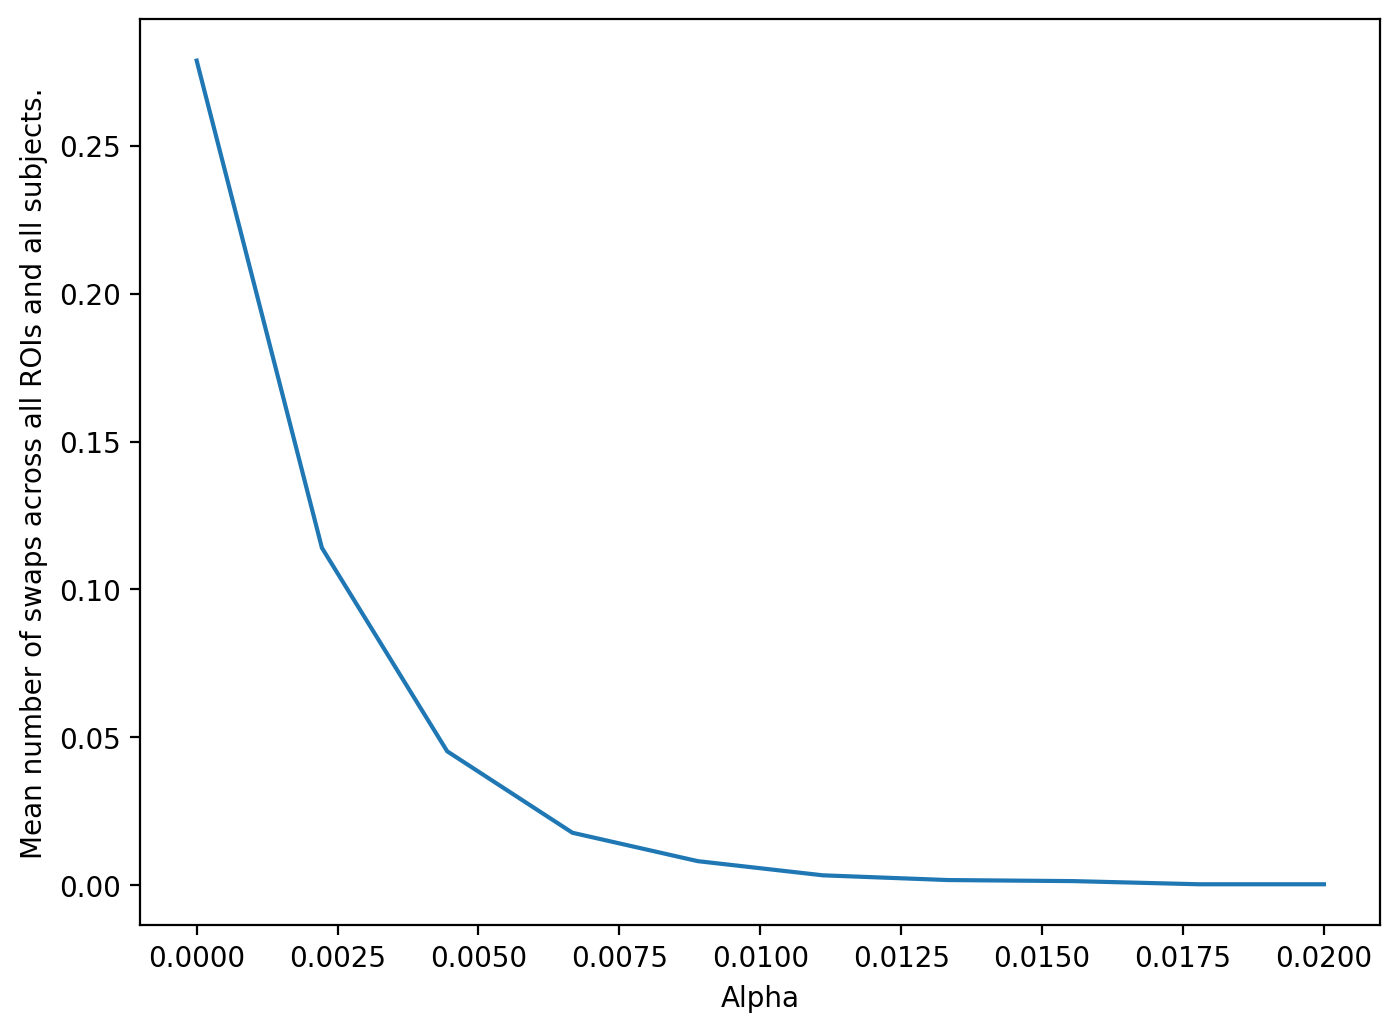

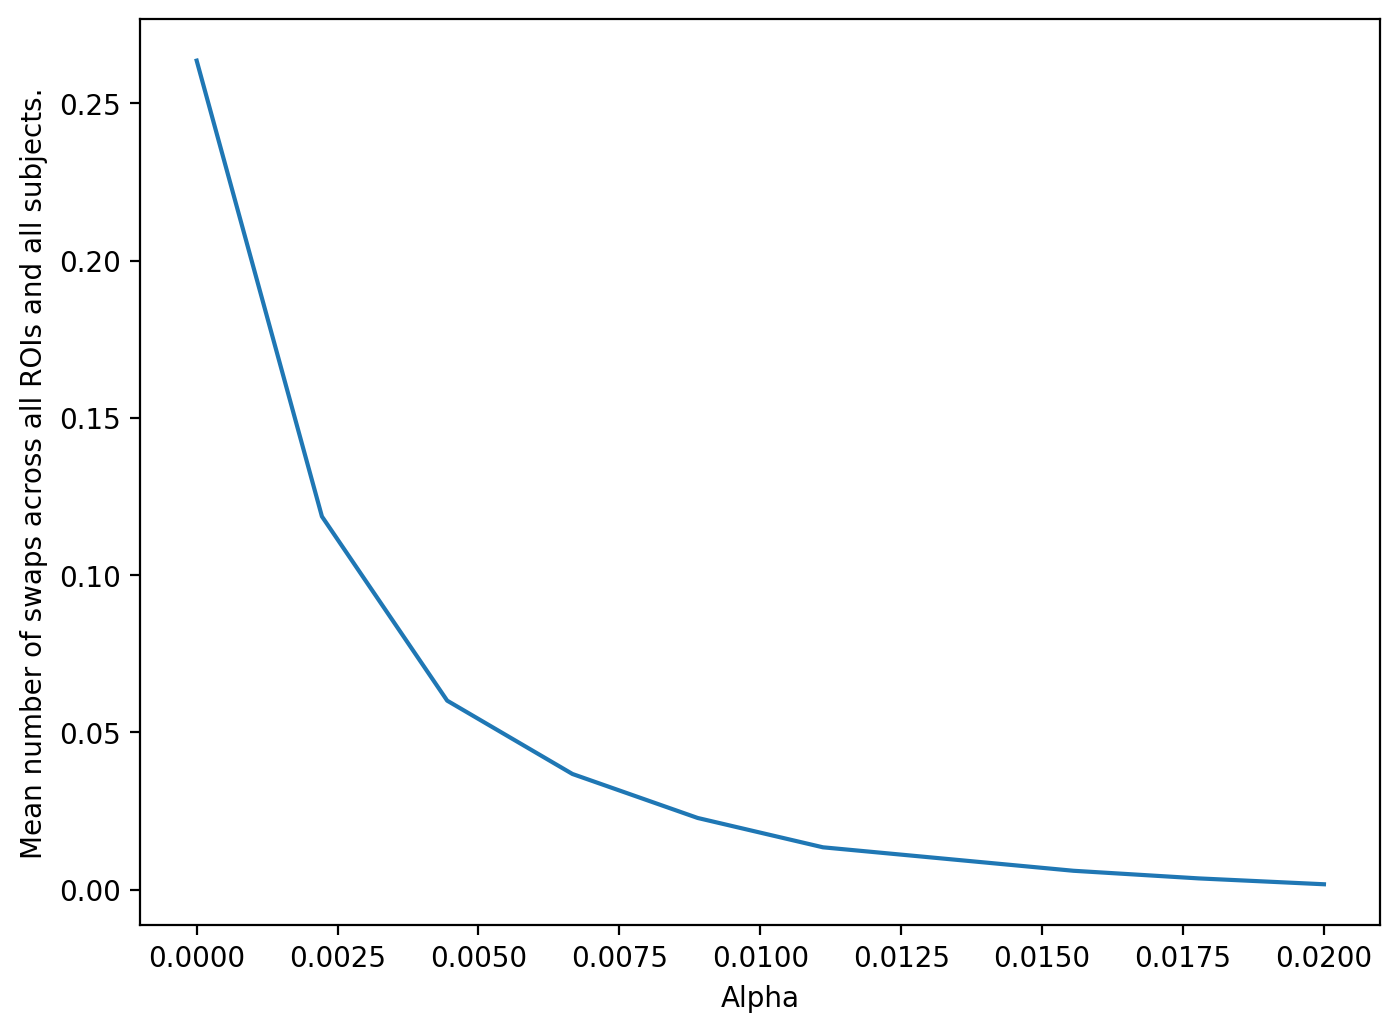

In [55]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cwd = os.getcwd()
data_dir = str(cwd) + '/data'
fc_dir =data_dir + '/precision/'

alpha=np.linspace(0,0.02,10)
counter=0
for i in session_swaps:
    
    figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

    swaps=i[:][:][:]
    meanswaps=np.mean(swaps,axis=2)

    #plt.plot(alpha,meanswaps)
    #plt.ylabel('Mean number of swaps across all ROIs and all subjects.')
    #plt.xlabel('Alpha')
    #plt.text(opt_gamma-0.3, 0.5, 'optimal gamma = ' + str(opt_gamma[0][0]))

    results_dir = str(cwd) + '/results/'
    plt.savefig(results_dir + str('numswaps_vs_alpha' + str(counter) +'_stroke.png'))
    counter=counter+1
